# Predicting Austin Animal Center Outcomes #

**Project group:** Julia Benginow, Yassine Jebbouri, Nate Mikosh, Esther Yoon

For our final project, we create a model to predict adoption outcomes of animals in the Austin Animal Center. Our model can aid in understanding the trends and characteristics of animals that are likely to be adopted. With this knowledge, it may be easier for shelters like the Austin Animal Center to prepare for certain scenarios, such as a large influx of "less adoptable" animals into the center. Additionally, it may be easier for the center to understand that one animal may be less likely to be adopted, and use my aggressive marketing strategies when it comes to that animal.

## About the Dataset ##

The dataset contains data collected by the Austin Animal Center from October 2013 to October 2023. It contains adoption outcomes and characteristics of animals that have been processed by the center, including the type of animal, breed, and time of adoption. There are 12 attributes and over 150,000 points in the dataset.


The dataset can be found here: https://catalog.data.gov/dataset/austin-animal-center-outcomes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install and Import Dependencies ##

In [ ]:
!pip install levenshtein
!pip install yellowbrick

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import Levenshtein
import zipfile
from sklearn.neighbors import NearestNeighbors
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas import DataFrame
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import DBSCAN
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict


## Create Dataframe ##

Read the dataset into a dataframe and see what features we have available so we can proceed with data cleaning and feature engineering.

We perform data exploration in tandem with data cleaning and feature engineering.

In [ ]:
data = pd.read_csv("Austin_Animal_Center_Outcomes.csv")
data.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


## Data Cleaning ##

Here, we output the size of the dataset. On top of that, in order to understand what we need to do with each feature, we need to understand the dimensionality of each categorical feature, such as animal types, breeds, and colors.

If we want to do binary classification, we need to see all of the outcome types and gather them into either adopted or not adopted categories. We will try clustering as well, to see if outcome types can be effectively grouped in other ways.

In [ ]:
# Size of data set
print('Entry count:', len(data))
# Outcome types
print('Outcome types: ', data["Outcome Type"].unique())

Entry count: 157061
Outcome types:  ['Rto-Adopt' 'Adoption' 'Euthanasia' 'Transfer' 'Return to Owner' 'Died'
 'Disposal' 'Missing' 'Relocate' nan 'Stolen']



Next, we `describe` the data. Two qualities of note are the uniqueness count of breeds (2885) and colors (636). These attributes are categorical in nature, and we don't want to be haunted by the curse of dimensionality, so we need to find some other way to encode these features than traditional one-hot encoding. This will be addressed later in the Feature Engineering section.

In [ ]:
data.describe()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
count,157061,111887,157061,157061,157061,157031,72367,157061,157059,157054,157061,157061
unique,140879,27422,130834,122,8145,10,26,5,5,54,2885,636
top,A721033,Max,04/18/2016 12:00:00 AM,Jun 2019,05/01/2016,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,33,675,39,2244,120,74100,37401,86852,54985,26270,33606,16376


Additionally, we need to understand how many null values each category has. For example, since we are missing so many `Name` and `Outcome Subtype` values, we may want to remove the category altogether. On the other hang, we may possibly be able to impute something like `Sex upon Outcome` based off of the animal's name. Finally, we'll need to remove rows that are missing labels.

In [ ]:
# Observe missing values
print(data.isnull().sum())
print("Total:", data.isnull().sum().sum())

Animal ID               0
Name                45174
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type           30
Outcome Subtype     84694
Animal Type             0
Sex upon Outcome        2
Age upon Outcome        7
Breed                   0
Color                   0
dtype: int64
Total: 129907


### Imputations and Removals ###

In the below two cells, we impute `Sex` as mentioned above. We first observe the datapoints missing `Sex`.

In [ ]:
nan_sex_rows = data[data['Sex upon Outcome'].isna()]
print('Rows with no Sex value:')
nan_sex_rows.head()

Rows with no Sex value:


,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
51895,A830333,Test,10/12/2022 02:51:00 PM,Oct 2022,10/12/2022,Return to Owner,NaN,Dog,NaN,NaN,Kuvasz,Unknown
78035,A667395,Diego,11/27/2013 04:11:00 PM,Nov 2013,11/17/2006,Return to Owner,NaN,Dog,NaN,7 years,Dachshund,Brown Merle


We assume the gender of Diego is male, and that 'Test' is a dummy data point (because why would
you name your pet Test). Additionally, males are classified as either "Neutered" or "Intact" within this attribute, we chose the most common of the two for imputing.

In [ ]:
neutered_counts = data['Sex upon Outcome'].value_counts().get('Neutered Male', 0)
intact_counts = data['Sex upon Outcome'].value_counts().get('Intact Male', 0)
print(f"neutered males: {neutered_counts}, intact males: {intact_counts}")

diego_index = nan_sex_rows.index[0]
data.loc[diego_index, 'Sex upon Outcome'] = 'Neutered Male'

data = data.drop(nan_sex_rows.index[1])

# No more NaN Sex values left!
data[data['Sex upon Outcome'].isna()].head()

neutered males: 54985, intact males: 20243


,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color


Additionally, we found that a lot of datapoints had `Sex` set as "Unknown". We justify removing rows with 'Unknown' outcomes because a small percentage of
datapoints are unknown in an already large dataset, and sex is difficult to impute
in a meaningful way. Additionally, we considered one-hot encoding each sex and
then dropping the "Unknown" sex, but we didn't want the lack of sex data to
influence training.

We convert `Sex` to one-hot encodings.

In [ ]:
# Check for "Unknown" Sex
unknown_sex = data[data['Sex upon Outcome'] == 'Unknown']
print(f"There are {len(unknown_sex)} unknown sexes")
data = data.drop(unknown_sex.index)
# Check that Unknown sex data points are removed
data[data['Sex upon Outcome'] == 'Unknown'].head()

There are 12206 unknown sexes


,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color


In [ ]:
# Now, create one-hot encoding for sex
data = pd.get_dummies(data, columns=['Sex upon Outcome'], prefix=['Sex upon Outcome'])
data.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Age upon Outcome,Breed,Color,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,2 years,Domestic Shorthair Mix,Brown Tabby/White,0,0,1,0
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,1 year,Chihuahua Shorthair Mix,White/Brown,0,0,1,0
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,4 months,Anatol Shepherd/Labrador Retriever,Buff,0,0,1,0
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,6 days,Domestic Shorthair Mix,Orange Tabby,0,1,0,0
5,A659412,Princess,10/05/2020 02:37:00 PM,Oct 2020,03/24/2013,Adoption,NaN,Dog,7 years,Chihuahua Shorthair Mix,Brown,0,0,0,1


There are a few "Unknown" values for breed. Since the count is neglible, we remove these rows.

In [ ]:
unknown_breed = data['Breed'].str.contains('Unknown')
print(f"Number of unknown breeds: {unknown_breed.sum()}")
data = data[~unknown_breed]

Number of unknown breeds: 8


We similarly drop null `Age` data points, since there are only 10.


In [ ]:
data = data.dropna(subset=['Age upon Outcome'])

### Removing Irrelevant Features ###

Next, we remove the following irrelevant features:
- `Animal ID` doesn't tell us anything about the datapoint.
- `Name` is unimportant, although one could consider using semantic analysis to map to positive/negative names and see if it has an effect (this is beyond the scope of this project).
- `DateTime` is too specific, we decided to focus on month and year instead.
- `Date of Birth` is essentially equivalent to the age upon outcome, so we remove it for redundancy.
- `Outcome Subtype` is removed since it only serves to further specify a subset of outcome types.

In [ ]:
data.drop(columns=['Animal ID', 'Name', 'DateTime', 'Date of Birth', 'Outcome Subtype'], axis=1, inplace=True)

# Remove unknown outcome types, as this equates to having no label
data = data.dropna(subset=['Outcome Type'])
data.head()

,MonthYear,Outcome Type,Animal Type,Age upon Outcome,Breed,Color,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female
0,May 2019,Rto-Adopt,Cat,2 years,Domestic Shorthair Mix,Brown Tabby/White,0,0,1,0
1,Jul 2018,Adoption,Dog,1 year,Chihuahua Shorthair Mix,White/Brown,0,0,1,0
3,Feb 2016,Adoption,Dog,4 months,Anatol Shepherd/Labrador Retriever,Buff,0,0,1,0
4,Mar 2014,Transfer,Cat,6 days,Domestic Shorthair Mix,Orange Tabby,0,1,0,0
5,Oct 2020,Adoption,Dog,7 years,Chihuahua Shorthair Mix,Brown,0,0,0,1


### Imputing Animal Type ###

To fix null values for `Animal Type`, it is enough to impute the `Breed` of the animal into `Animal Type`. This is because cats and dogs will always have a type listed, and the dataset creators chose to specify other types of animals within the `Breed` column.

In [ ]:
# Impute 'Other' Animal Type with Breed
def replace_other_animal(row):
  if row['Animal Type'] == 'Other' and row['Breed'] is not None:
    return row['Breed']
  return row['Animal Type']

data['Animal Type'] = data.apply(replace_other_animal, axis=1)

# Display newly imputed values
other_animal_types = data[(data['Animal Type'] != 'Cat') & (data['Animal Type'] != 'Dog')]
other_animal_types.head()

,MonthYear,Outcome Type,Animal Type,Age upon Outcome,Breed,Color,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female
53,Dec 2019,Adoption,Polish,6 months,Polish,White/White,0,0,0,1
197,Feb 2017,Transfer,Guinea Pig Mix,9 months,Guinea Pig Mix,Tricolor,0,1,0,0
229,Mar 2016,Adoption,Bird,1 year,Chicken Mix,Black/Red,0,1,0,0
454,May 2015,Transfer,Guinea Pig Mix,4 years,Guinea Pig Mix,Brown/Orange,1,0,0,0
582,May 2015,Return to Owner,Ferret Mix,1 year,Ferret Mix,Black/White,0,0,1,0


# Feature Engineering

*italicised text*### Creating new features from MonthYear ###

We want to learn from either the year or the month (for example, a given year may see an uptick in adoptions due to different events, for example Covid). We created a seasons category to condense the months, given that seasons are fairly generalizable.

In [ ]:
# Make one-hot encodings for categorical features

# Change month/year to season and year
spring = ['Mar', 'Apr', 'May']
fall = ['Sep', 'Oct', 'Nov']
winter = ['Dec', 'Jan', 'Feb']
summer = ['Jun', 'Jul', 'Aug']

def month_to_season(row):
  if row['Season'] in spring:
    return 'Spring'
  elif row['Season'] in fall:
    return 'Fall'
  elif row['Season'] in winter:
    return 'Winter'
  elif row['Season'] in summer:
    return 'Summer'
  return None

data[['Season', 'Year']] = data['MonthYear'].str.split(' ', 1, expand=True)
data['Year'] = data['Year'].astype(int)

# Now we can remove the MonthYear column
data.drop('MonthYear', axis=1, inplace=True)

data['Season'] = data.apply(month_to_season, axis=1)

# Create one-hot encodings for seasons
data = pd.get_dummies(data, columns=['Season'], prefix=['Season'])

data.head()


<ipython-input-21-ee7e7e836cf3>:20: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data[['Season', 'Year']] = data['MonthYear'].str.split(' ', 1, expand=True)


,Outcome Type,Animal Type,Age upon Outcome,Breed,Color,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Year,Season_Fall,Season_Spring,Season_Summer,Season_Winter
0,Rto-Adopt,Cat,2 years,Domestic Shorthair Mix,Brown Tabby/White,0,0,1,0,2019,0,1,0,0
1,Adoption,Dog,1 year,Chihuahua Shorthair Mix,White/Brown,0,0,1,0,2018,0,0,1,0
3,Adoption,Dog,4 months,Anatol Shepherd/Labrador Retriever,Buff,0,0,1,0,2016,0,0,0,1
4,Transfer,Cat,6 days,Domestic Shorthair Mix,Orange Tabby,0,1,0,0,2014,0,1,0,0
5,Adoption,Dog,7 years,Chihuahua Shorthair Mix,Brown,0,0,0,1,2020,1,0,0,0


### Converting All Ages to Years ###
`Age upon Outcome` lists the age of the animal when it leaves the center in either years, months, or days. We convert the string representation of age into a float representing age in years.

In [ ]:
def cast_to_int(str):
  try:
    int(str)
    return int(str)
  except ValueError:
    return None

# Given any age, we want to convert it to some number of years
def age_to_years(row):
  # we take absolute value of years, since some rows had a negative numerical value input
  # assume that negative value implies human error
  age = abs(cast_to_int(row['Age upon Outcome'].split(' ')[0]))
  if age < 0:
    print(row)
  if "year" in row['Age upon Outcome']:
    return age
  elif "month" in row['Age upon Outcome']:
    if age is not None:
      return age / 12
    else:
      return None
  elif "week" in row['Age upon Outcome']:
    if age is not None:
      return age / 52
    else:
      return None
  elif "day" in row['Age upon Outcome']:
    if age is not None:
      return age / 365
    else:
      return None
  else:
    # This should never happen
    return None

data["Age (years)"] = data.apply(age_to_years, axis=1)
data.drop(columns = ['Age upon Outcome'], axis=1, inplace=True)

data.head()

,Outcome Type,Animal Type,Breed,Color,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Year,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Age (years)
0,Rto-Adopt,Cat,Domestic Shorthair Mix,Brown Tabby/White,0,0,1,0,2019,0,1,0,0,2.000000
1,Adoption,Dog,Chihuahua Shorthair Mix,White/Brown,0,0,1,0,2018,0,0,1,0,1.000000
3,Adoption,Dog,Anatol Shepherd/Labrador Retriever,Buff,0,0,1,0,2016,0,0,0,1,0.333333
4,Transfer,Cat,Domestic Shorthair Mix,Orange Tabby,0,1,0,0,2014,0,1,0,0,0.016438
5,Adoption,Dog,Chihuahua Shorthair Mix,Brown,0,0,0,1,2020,1,0,0,0,7.000000


We check that there are no outliers in the ages. Given that the animal with the highest age, 30, its a macaw (which usually live between 30-45 years), this is reasonable. We don't need to prune any outliers.

After plotting, we found that some ages were negative. We reran the code above in order to take the absolute value of each age and attributed negative values to human error.

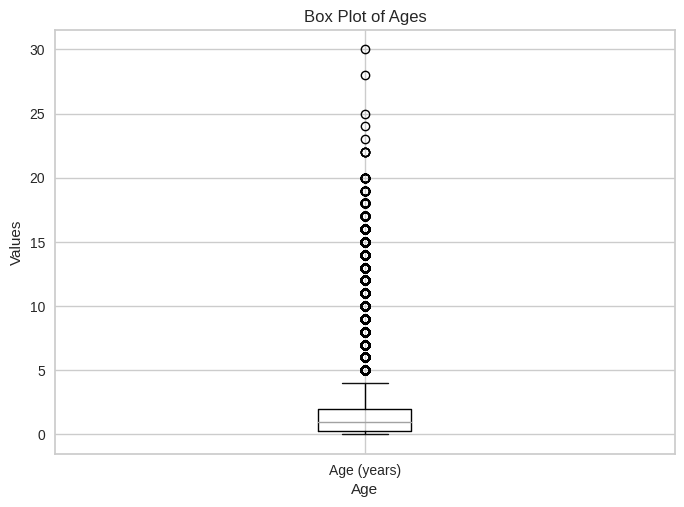

Row with the highest age:
Outcome Type                       Transfer
Animal Type                            Bird
Breed                                 Macaw
Color                             Blue/Gold
Sex upon Outcome_Intact Female            1
Sex upon Outcome_Intact Male              0
Sex upon Outcome_Neutered Male            0
Sex upon Outcome_Spayed Female            0
Year                                   2021
Season_Fall                               1
Season_Spring                             0
Season_Summer                             0
Season_Winter                             0
Age (years)                            30.0
Name: 56145, dtype: object


In [ ]:
data.boxplot(column='Age (years)')
plt.xlabel('Age')
plt.ylabel('Values')
plt.title('Box Plot of Ages')
plt.show()

max_age_index = data['Age (years)'].idxmax()
row_with_max_age = data.loc[max_age_index]

print("Row with the highest age:")
print(row_with_max_age)

## Rare Animal Types ##
Cats and dogs are the most common animals in the data set. There are also a non-neglible amount of other animal types, the 40 most common of which we graph below. Observe that **most rare animal types are smaller** animals like rodents and birds. We will use this observation to make an assumption when we compute animal weights later.

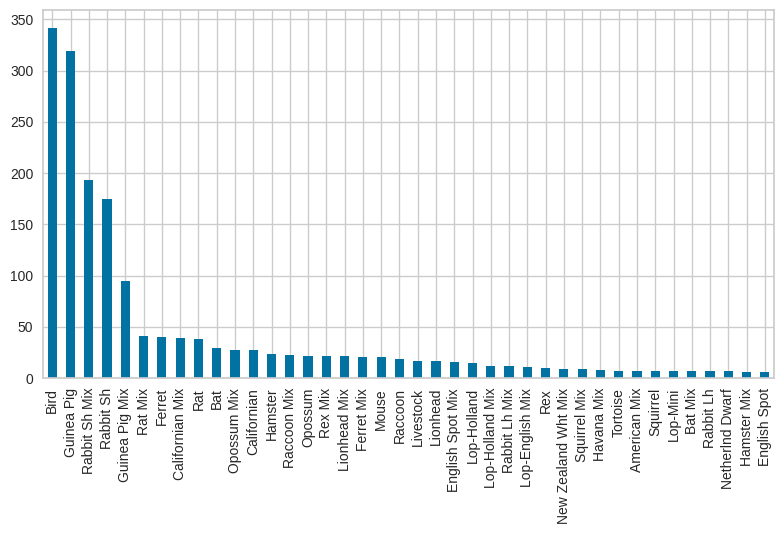

In [ ]:
rare_animal_types = data[~data['Animal Type'].isin(['Cat', 'Dog'])]

# Examine how often different rare animal types appear
rare_animal_types['Animal Type'].value_counts().nlargest(40).plot(kind='bar')
plt.tight_layout()
plt.show()

We'll use the observations above later. For now, we will combine rare animal types into one `Other` category and one-hot encode `Animal Type`.

In [ ]:
def cat_dog_other(row):
  if row['Animal Type'] == 'Cat':
    return 'Cat'
  elif row['Animal Type'] == 'Dog':
    return 'Dog'
  else:
    return 'Other'

data['Animal Type'] = data.apply(cat_dog_other, axis=1)
data = pd.get_dummies(data, columns=['Animal Type'], prefix=['Animal_Type'])
data.head()

,Outcome Type,Breed,Color,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Year,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Age (years),Animal_Type_Cat,Animal_Type_Dog,Animal_Type_Other
0,Rto-Adopt,Domestic Shorthair Mix,Brown Tabby/White,0,0,1,0,2019,0,1,0,0,2.000000,1,0,0
1,Adoption,Chihuahua Shorthair Mix,White/Brown,0,0,1,0,2018,0,0,1,0,1.000000,0,1,0
3,Adoption,Anatol Shepherd/Labrador Retriever,Buff,0,0,1,0,2016,0,0,0,1,0.333333,0,1,0
4,Transfer,Domestic Shorthair Mix,Orange Tabby,0,1,0,0,2014,0,1,0,0,0.016438,1,0,0
5,Adoption,Chihuahua Shorthair Mix,Brown,0,0,0,1,2020,1,0,0,0,7.000000,0,1,0


### Converting Color Categories ###

We want to convert `Color` into some numerical representation. However, the number of unique color types that appear are larger than practical for using one-hot encodings.

However, we noticed a few things when we plot the color frequencies.
- There are a few colors that repeat much more often than others (e.g. "White" appears frequently).
- There are colors that are very similar under different names, for example, "Brown" and "Chocolate".

We took these observations into account and created one-hot encodings for groups of colors that are similar.

Unique colors: 614


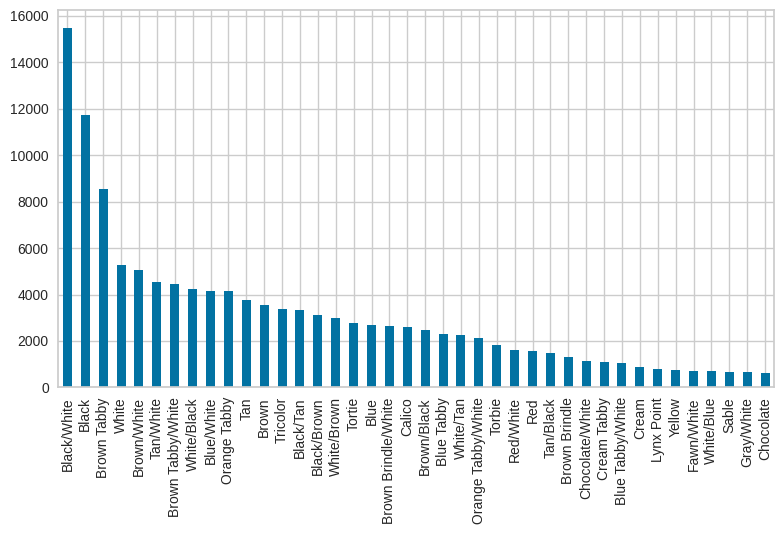

In [ ]:
# Count number of unique colors
print('Unique colors:', data['Color'].nunique())

# Examine how often different Color values appear
data['Color'].value_counts().nlargest(40).plot(kind='bar')
plt.tight_layout()
plt.show()

We create multi-selection one-hot mappings for the most commonly-occuring
colors, and lump any additional colors into an "Other" category.

In [ ]:


black = ['black']
white = ['white', 'cream']
brown = ['brown', 'tan', 'chocolate', 'fawn', 'sable']
orange = ['red', 'orange', 'yellow']
rainbow = ['tricolor', 'calico', 'tortie', 'torbie']
patterned = ['lynx point', 'tabby']
color_map = {'Black': black, 'White': white, 'Brown': brown, 'Orange': orange, 'Rainbow': rainbow, 'Patterned': patterned}

def color_in_str(lst, str):
  for col in lst:
    if col in str:
      return True
  return False

def convert_color(row):
  colors = []
  color_str = row['Color'].lower()
  for color_name, color_list in color_map.items():
    if color_in_str(color_list, color_str):
      colors.append(color_name)

  if len(colors) == 0:
    return ['Other']
  return colors

data['Colors'] = data.apply(convert_color, axis=1)

data.head()

,Outcome Type,Breed,Color,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Year,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Age (years),Animal_Type_Cat,Animal_Type_Dog,Animal_Type_Other,Colors
0,Rto-Adopt,Domestic Shorthair Mix,Brown Tabby/White,0,0,1,0,2019,0,1,0,0,2.000000,1,0,0,"[White, Brown, Patterned]"
1,Adoption,Chihuahua Shorthair Mix,White/Brown,0,0,1,0,2018,0,0,1,0,1.000000,0,1,0,"[White, Brown]"
3,Adoption,Anatol Shepherd/Labrador Retriever,Buff,0,0,1,0,2016,0,0,0,1,0.333333,0,1,0,[Other]
4,Transfer,Domestic Shorthair Mix,Orange Tabby,0,1,0,0,2014,0,1,0,0,0.016438,1,0,0,"[Orange, Patterned]"
5,Adoption,Chihuahua Shorthair Mix,Brown,0,0,0,1,2020,1,0,0,0,7.000000,0,1,0,[Brown]


From this conversion, we create many-hot encodings for `Colors` where a data point can have multiple color values.

In [ ]:
encoded_colors = pd.get_dummies(data['Colors'].apply(pd.Series).stack()).sum(level=0)
data = pd.concat([data, encoded_colors], axis=1)
# Remove the original Color features and the Colors feature we used for one-hot encodings
data.drop('Color', axis=1, inplace=True)
data.drop('Colors', axis=1, inplace=True)
data.head()

<ipython-input-28-965da37a318c>:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  encoded_colors = pd.get_dummies(data['Colors'].apply(pd.Series).stack()).sum(level=0)


,Outcome Type,Breed,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Year,Season_Fall,Season_Spring,Season_Summer,...,Animal_Type_Cat,Animal_Type_Dog,Animal_Type_Other,Black,Brown,Orange,Other,Patterned,Rainbow,White
0,Rto-Adopt,Domestic Shorthair Mix,0,0,1,0,2019,0,1,0,...,1,0,0,0,1,0,0,1,0,1
1,Adoption,Chihuahua Shorthair Mix,0,0,1,0,2018,0,0,1,...,0,1,0,0,1,0,0,0,0,1
3,Adoption,Anatol Shepherd/Labrador Retriever,0,0,1,0,2016,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,Transfer,Domestic Shorthair Mix,0,1,0,0,2014,0,1,0,...,1,0,0,0,0,1,0,1,0,0
5,Adoption,Chihuahua Shorthair Mix,0,0,0,1,2020,1,0,0,...,0,1,0,0,1,0,0,0,0,0


Through this method, we get high coverage of the colors, and are unable to classify the color of only 4% of the datapoints.

In [ ]:
other_color_count = (data['Other'] == 1).sum()
percent_covered = round(100 * other_color_count / len(data), 2)
print(f"Did not cover {other_color_count} / {len(data)} colors, {percent_covered} %")

Did not cover 5884 / 144821 colors, 4.06 %


### Breed feature extraction ###

Given that we have many breeds, but we can't do a similar binning tactic as we did above, we need to figure a way to use the breed information without one-hot encoding something with so many categories.

We came up with two features to encode the idea of breed:
#### 1. Frequency Mappings ####
We do this just to see whether people may be more interested in more common breed types, or whether people are more interested in adopting rarer animal types.

#### 2. Weight Feature ####
The idea is to map dog breeds to their average weights, cats to the average weight of a housecat (with the exception of Maine Coons, which are large), and other animals to one pound, since in our data exploration we realized that most of the other animal types are relatively small (see "Rare Animal Types" section).

We use [this](https://github.com/MeganSorenson/American-Kennel-Club-Breeds-by-Size-Dataset/blob/main/AmericanKennelClubBreedsBySize.xlsx) dataset from the American Kennel Club to map dog breeds to their average weights.

We make these mappings by using edit distance to map the dog breed weight to the average weight of the breed based off of the weight dataset. We set a minimum edit distance to be classified as one of these breeds.

In [ ]:
# Create a frequency mapping for Breed
data['Breed Frequency'] = data['Breed'].map(data['Breed'].value_counts())
data.head()

,Outcome Type,Breed,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Year,Season_Fall,Season_Spring,Season_Summer,...,Animal_Type_Dog,Animal_Type_Other,Black,Brown,Orange,Other,Patterned,Rainbow,White,Breed Frequency
0,Rto-Adopt,Domestic Shorthair Mix,0,0,1,0,2019,0,1,0,...,0,0,0,1,0,0,1,0,1,30627
1,Adoption,Chihuahua Shorthair Mix,0,0,1,0,2018,0,0,1,...,1,0,0,1,0,0,0,0,1,6713
3,Adoption,Anatol Shepherd/Labrador Retriever,0,0,1,0,2016,0,0,0,...,1,0,0,0,0,1,0,0,0,38
4,Transfer,Domestic Shorthair Mix,0,1,0,0,2014,0,1,0,...,0,0,0,0,1,0,1,0,0,30627
5,Adoption,Chihuahua Shorthair Mix,0,0,0,1,2020,1,0,0,...,1,0,0,1,0,0,0,0,0,6713


In [ ]:
# Download the American Kennel Club Breeds-by-Size dataset
!wget https://github.com/MeganSorenson/American-Kennel-Club-Breeds-by-Size-Dataset/raw/main/AmericanKennelClubBreedsBySize.xlsx

--2023-11-19 09:15:09--  https://github.com/MeganSorenson/American-Kennel-Club-Breeds-by-Size-Dataset/raw/main/AmericanKennelClubBreedsBySize.xlsx
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MeganSorenson/American-Kennel-Club-Breeds-by-Size-Dataset/main/AmericanKennelClubBreedsBySize.xlsx [following]
--2023-11-19 09:15:10--  https://raw.githubusercontent.com/MeganSorenson/American-Kennel-Club-Breeds-by-Size-Dataset/main/AmericanKennelClubBreedsBySize.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24622 (24K) [application/octet-stream]
Saving to: ‘AmericanKennelClubBreedsBySize.xlsx’

A

In [ ]:
# Create the weight feature

not_found_in_kc_dataset = {}

def edit_distance_score(str1, str2):
  edit_distance = Levenshtein.distance(str1, str2)
  max_length = max(len(str1), len(str2))
  return ((1.0) * edit_distance) / max_length

sizes = pd.read_excel("AmericanKennelClubBreedsBySize.xlsx")

def get_highest_edit_distance(strn):
  index = -1
  closest_edit_distance = 999.0
  for index, row in sizes.iterrows():
    dist = edit_distance_score(strn, row['Breed'])
    if (dist < closest_edit_distance):
      closest_edit_distance = dist
      index = index
  # a hyperparameter that we have tested. tried and true.
  if (closest_edit_distance > .6):
    if strn in not_found_in_kc_dataset:
        # If it is, increment the frequency
        not_found_in_kc_dataset[strn] += 1
    else:
        # If it's not, add it to the dictionary with a frequency of 1
        not_found_in_kc_dataset[strn] = 1
    # If there is no match, we return the average weight of a medium-sized dog
    return 50.0
  return sizes.iloc[index]['Avg Weight (pounds)']

# Now, we will map breed to size for dogs
def create_size_mapping(row):
  if row['Animal_Type_Dog'] == 1:
    if 'pit bull' in row['Breed'].lower():
      return 50.0
    elif 'pitbull' in row['Breed'].lower():
      return 50.0
    elif 'chihuahua' in row['Breed'].lower():
      return 5.0
    elif 'black mouth cur' in row["Breed"].lower():
      return 50.0
    elif 'beagle' in row["Breed"].lower():
      return 25.0
    elif 'collie' in row["Breed"].lower():
      return 60.0
    elif 'pbgv' in row["Breed"].lower():
      return 38.5
    elif 'blue lacy' in row["Breed"].lower():
      return 40.0
    elif 'heeler' in row["Breed"].lower():
      return 41.0
    elif 'bernard' in row["Breed"].lower():
      return 140.0
    elif 'landseer' in row["Breed"].lower():
      return 140.0
    return get_highest_edit_distance(row['Breed'])
  elif row['Animal_Type_Cat'] == 1:
    if row['Breed'] == 'Maine Coon':
      return 13
    else:
      return 9
  else:
    # For rare animals, we assume that they are almost always
    # small (on the scale of rodents and birds)
    return 1.0

data['Weight (lbs)'] = data.apply(create_size_mapping, axis=1)
data.drop(columns=["Breed"], axis=1, inplace=True)
data.head()

During feature engineering for `Breed`, we used this code block to see which breeds were commonly not found in the American Kennel Club dataset. We then just googled the average weight of each of the more common breeds to impute it, and the less common breeds were assigned the size of a standard medium-sized dog because we found that many of the remaining breeds that were not matched were mostly average-sized dogs.

In [ ]:
def visualize_frequencies(frequency_dict):
    items = list(frequency_dict.keys())
    frequencies = list(frequency_dict.values())
    it = []
    freqs = []

    for i, freq in enumerate(frequencies):
      if freq > 1:
        it.append(items[i])
        freqs.append(freq)

    plt.bar(it, freqs)
    plt.xlabel('Items')
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    plt.title('Frequency of Items')
    plt.show()

visualize_frequencies(not_found_in_kc_dataset)

## Final Datasets ##
Since we want to perform both binary and multiclass modeling, we create two datasets for each use case. The multicass dataset is unchanged from prior modifications. The binary dataset groups `Outcome Type`s into two categories based on whether they conform to an adopted status or not. We label "Adopted" with 1 and "Not Adopted" with 0.

In [ ]:
 # Make a dataset for binary classification
adopted_features = ['Rto-Adopt', 'Adoption', 'Return to Owner', 'Stolen']
not_adopted_features = ['Euthanasia', 'Died', 'Disposal', 'Missing', 'Transfer', 'Relocate']

adopted_mapping = {feature: 1 for feature in adopted_features}
not_adopted_mapping = {feature: 0 for feature in not_adopted_features}

column_mapping = {}
column_mapping.update(adopted_mapping)
column_mapping.update(not_adopted_mapping)
print(column_mapping)

def make_binary(row):
  value = column_mapping.get(row['Outcome Type'])
  if value is not None:
    return value
  else:
    return -1

binclass_data = data.copy(deep=True)
binclass_data['Outcome Type'] = binclass_data.apply(make_binary, axis=1)

# Make a dataset for clustering / multiclass
# No need to change anything
clustering_data = data.copy(deep=True)

In [ ]:
adoption_counts = binclass_data.groupby('Year')['Outcome Type'].sum()
plt.bar(adoption_counts.index, adoption_counts)

# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Number of adoptions)')
plt.title('Adoptions Over Time')

# Show the plot
plt.show()

In [ ]:
print(binclass_data.dtypes)

In [ ]:
binclass_data.head()

In [ ]:
clustering_data.head()

In [ ]:
# Save the dataframes to CSV files
binclass_data.to_csv('animal_outcomes_binary.csv', index=False)
clustering_data.to_csv('animal_outcomes_clustering.csv', index=False)

In [ ]:
# ma
binclass_data.isnull().sum()

Outcome Type                      0
Sex upon Outcome_Intact Female    0
Sex upon Outcome_Intact Male      0
Sex upon Outcome_Neutered Male    0
Sex upon Outcome_Spayed Female    0
Year                              0
Season_Fall                       0
Season_Spring                     0
Season_Summer                     0
Season_Winter                     0
Age (years)                       0
Animal_Type_Cat                   0
Animal_Type_Dog                   0
Animal_Type_Other                 0
Black                             0
Brown                             0
Orange                            0
Other                             0
Patterned                         0
Rainbow                           0
White                             0
Breed Frequency                   0
Weight (lbs)                      0
dtype: int64

# Modeling
We have our data in two main datasets, a dataset that divides the animals into 'adopted' and 'not adopted' and one that breaks it into every invidual class. We're unsure if the binary dataset will be easier to classify and cluster. One on hand, only having two classes will be much easier than having all ten. However, it's possible that the classes we grouped into 'adopted' and 'not adopted' are not similar enough in their data to be classified together.

In [ ]:
binary_data = pd.read_csv('animal_outcomes_binary.csv')
clusteringc_data = pd.read_csv("animal_outcomes_clustering.csv")

## Clustering Algorithms ##



Since clustering is an unsupervised learning technique, we do not need the labels, so will remove them for now and save them for later in the evaluation step.

In [ ]:
clustering_data_labels = clustering_data["Outcome Type"]
clustering_data_features = clustering_data.drop(columns = ["Outcome Type"])

First, we would like to check if our dataset has a high clustering tendency, for that we compute the hopkins score. Now, unfortunately, the library function that computes this score is no longer available on newer versions of Python, so we implemented our own function that computes the hopkins score.
In this version that we implemented, we calculate the hopkins score for an "n_trials" number of trials to solve the issue of randomness.


In [ ]:
warnings.filterwarnings('ignore')

def hopkins (X,sampling_size):
      hopkins_scores=[]
      n_trials=15

      for i in range (n_trials):
        X_sample=X.sample(n=sampling_size,replace=False) #we only work with a sample of the data
        random_points = pd.DataFrame(np.random.uniform(low=X.min(), high=X.max(), size=(sampling_size, X.shape[1]))) #we generate random points in the scale of our dataset
        nn = NearestNeighbors(n_neighbors=2).fit(X) # we get the nearest neighbor. Here we chose n_neighbors=2 because n_neighbors=1 will give us the point itself, and we don't want that.
        distances_from_X = nn.kneighbors(X_sample, return_distance=True)[0][:,1]
        distances_from_random = nn.kneighbors(random_points, return_distance=True)[0][:,1]
        hopkins_score=np.sum(distances_from_random)/(np.sum(distances_from_X)+np.sum(distances_from_random))
        hopkins_scores.append(hopkins_score)

      hopkins_avg=np.mean(hopkins_scores)
      return hopkins_avg

We will compute the hopkins score for only 7500 datapoints of our data

In [ ]:
sampling_size = 7500
hopkins_score = hopkins(clustering_data_features, sampling_size)
print("Hopkins statistic for raw data set is: ", hopkins_score)


Hopkins statistic for raw data set is:  0.999737589307328


We would like to attempt to observe the clustering tendancy of the dataset, but this is hard to plot in high dimensions. To do that, we will perform PCA with n_components=2 to project our data into a 2-dimensional space.

In [ ]:
# Scale the data, run PCA, then try Hopkin's statistic again
stdscaler = StandardScaler()
stdscaler.fit(clustering_data_features)
scaled_data = stdscaler.transform(clustering_data_features)
pca = PCA()

pca.n_components = 2
pca.svd_solver = 'full'
pca_data = pca.fit_transform(scaled_data)
refined_data = DataFrame(pca_data)



Here, we will try to visualize the data in 2 dimensions, after doing PCA


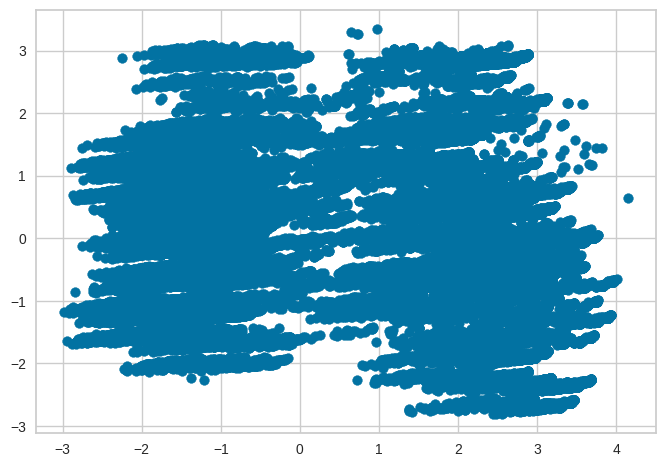

In [ ]:
plt.scatter(refined_data.iloc[:, 0], refined_data.iloc[:, 1])
plt.show()

Here we can see that the data has somewhat 2 distinct clusters, but within those we can also see some other clusters.

We will also look at the hopkins score for the scaled and PCA data set:

In [ ]:

hopkins_score = hopkins(refined_data, sampling_size)
print("Hopkins statistic for scaled and PCA data set is: ", hopkins_score)

Hopkins statistic for scaled and PCA data set is:  0.9782892550960695


Here we can see that the hopkins score is very high (almost 1), which suggests that the data has a high clustering tendency.

**Clustering using K-means**

To choose the best hyperparameters for K-means, we decided to use silouhette plots, because they combine both seperation and cohesion. We will also only run it on a subset of our data. This does not give very accurate results but it gives us an idea of the approach we would like to go for.

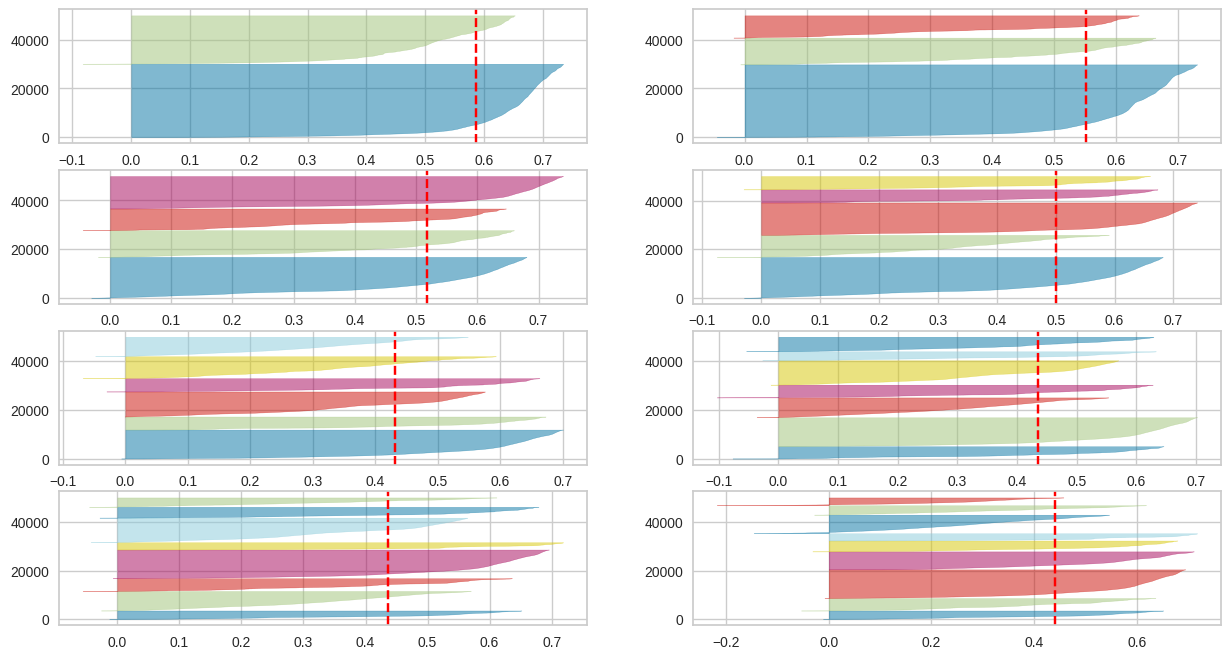

In [53]:
data_sample=refined_data.sample(n=50000,random_state=77)
fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7, 8, 9]:
    km = KMeans(n_clusters=i, random_state=77)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_sample)

From these silhouette plots, we can see that k=2 and k=3 both give the best results, we will use k=2 for now.


Now, we will be running the K-means algorithm using the k that gave us the best results.


In [54]:
k=2
kmeans = KMeans(n_clusters=k)
kmeans_labels=kmeans.fit_predict(refined_data)


Since we have labeled data, we decided to opt for external measures to evaluate our clustering. We use 2 metrics: the Adjusted Random Score, and the Normalized Mutual Info Score. More details about these metrics can be found on this page:
https://www.geeksforgeeks.org/clustering-performance-evaluation-in-scikit-learn/


In [55]:

ar_score = adjusted_rand_score(clustering_data_labels, kmeans_labels)
nmi_score = normalized_mutual_info_score(clustering_data_labels, kmeans_labels)

print("Adjusted random score is:",ar_score)
print("NMI score",nmi_score)

Adjusted random score is: 0.017898831941784217
NMI score 0.05082305219745902


We can see that the Adjusted Random score is close to 0 (range is [-1,1]), which means that the clustering was done randomly.
We also get a score close to 0 for the NMI score, which suggests that there is no mutual information between the cluster labels and the real labels.

**Clustering using DBSCAN**

Now, we want to try a different clustering approach, DBSCAN. We will plot the k-dist plot to find the best hyperparameters for this dataset.

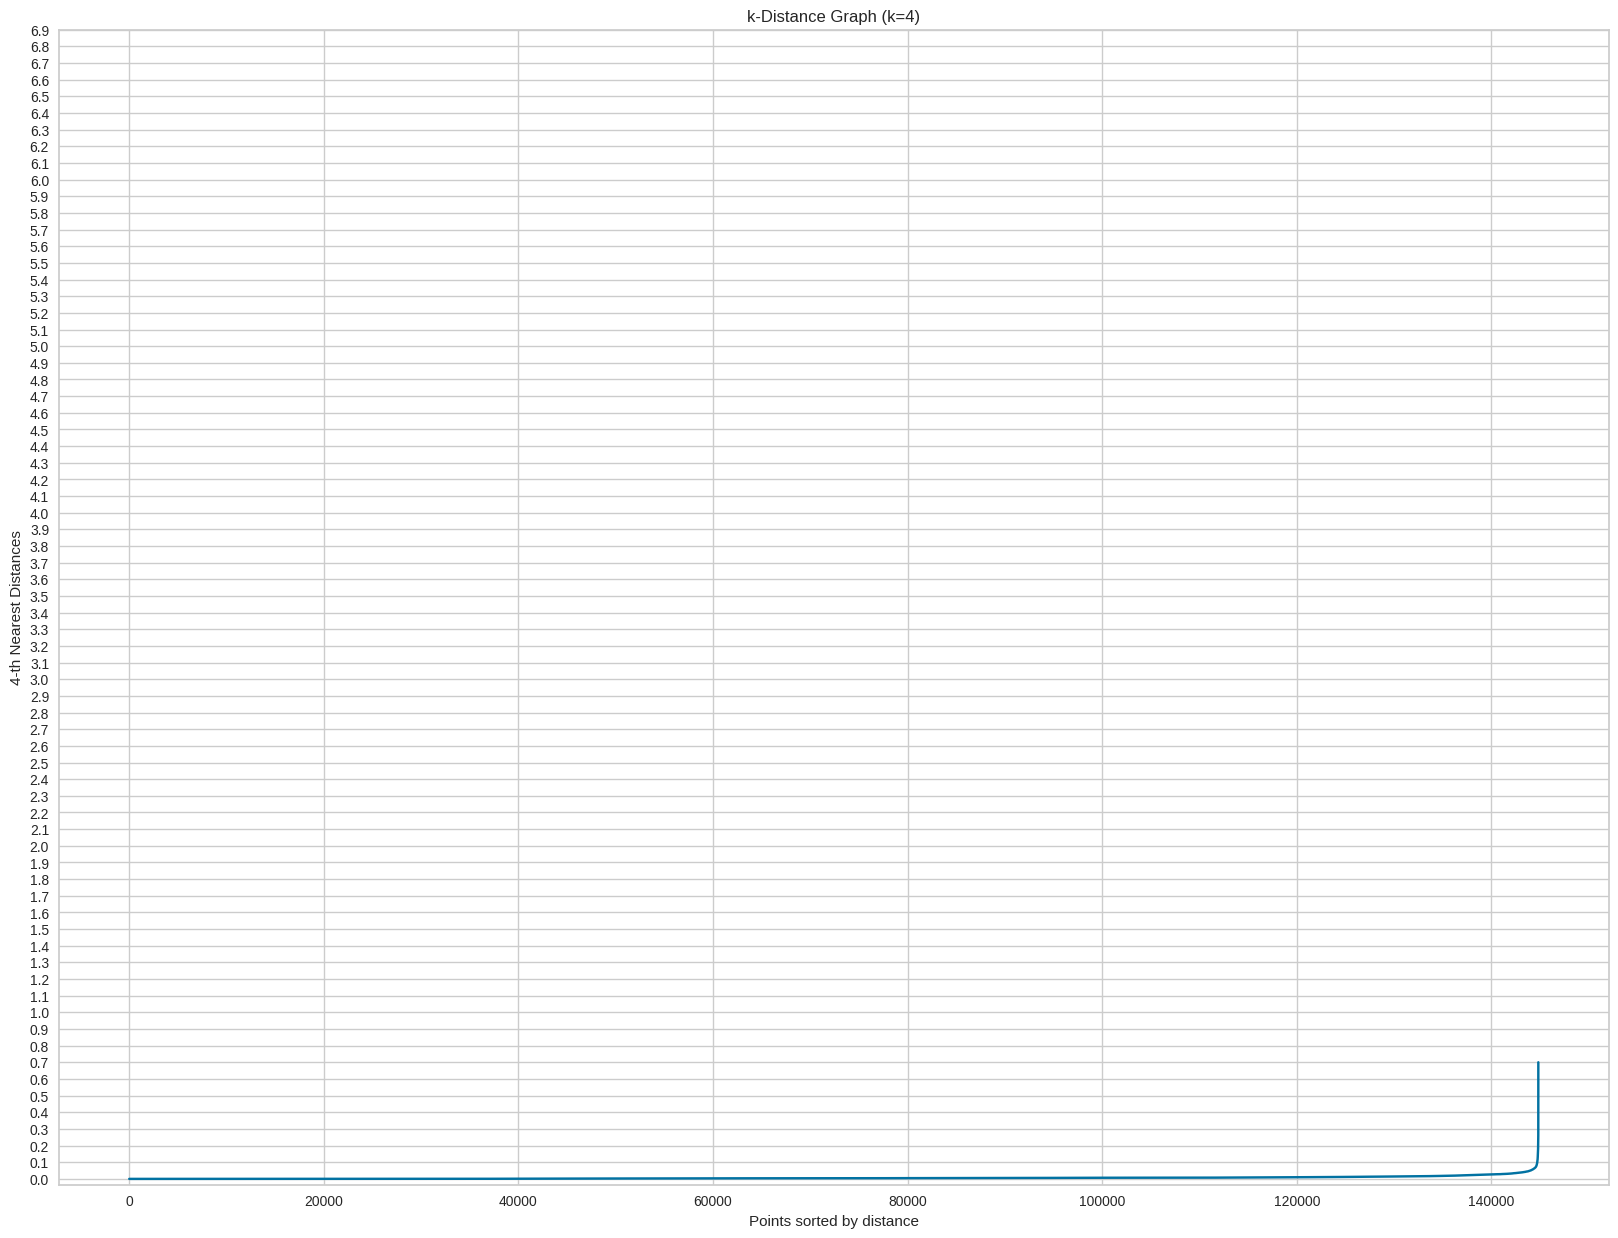

In [56]:
k = 4

nn=NearestNeighbors(n_neighbors=k)
nn.fit(refined_data)

# Find the distance to the k-th nearest neighbor for each point
distances, indices = nn.kneighbors(refined_data)
k_dist=distances[:,k-1]

# Sort the distances
sorted_k_dist=np.sort(k_dist)

# Plot the k-distance graph
plt.figure(figsize=(20, 15))
plt.plot(sorted_k_dist)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Distances')
plt.title(f'k-Distance Graph (k={k})')
plt.yticks(np.arange(0,7, 0.1))
plt.grid(True)
plt.show()

Now, we will run DBSCAN with eps=0.1 and min_pts=4

In [57]:

dbscan = DBSCAN(eps=0.1, min_samples=4)
clusters=dbscan.fit_predict(refined_data)
clusters_array=np.array(clusters)
print(np.unique(clusters_array)) #this displays the unique cluster labels


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [58]:
ar_score = adjusted_rand_score(clustering_data_labels, clusters_array)
nmi_score = normalized_mutual_info_score(clustering_data_labels,clusters_array)

print("Adjusted random score is:",ar_score)
print("NMI score",nmi_score)

Adjusted random score is: -0.010828314525939724
NMI score 0.012171040197035073


Using DBSCAN, we get more clusters than the number of labels, but not by a lot


Based on our analysis, which gave us a high Hopkins score, implying that our data has a high clustering tendancy, we expected clustering to work well. However, as you can see from the results of both algorithms used, the performance was bad when compared with the true labels.
There are many reasons as to why this might be happening:
-The data itself might have some clusters that do not necessarily match with the class labels.
-We may have engineered our data in a way that distorts some of the patterns seen in our data.
-the metrics used (ARI and NMI) suggest that the clustering result is largely independent of the true labels. It could be due to misalignment between the true cluster structure and what the algorithms are detecting.
-If the true clusters in the dataset overlap significantly, it may be challenging for algorithms like KMeans and DBSCAN to distinguish them.

While the approaches used for clustering did not perform well, maybe a fine-tuned version of these algorithm would have worked better. But for now, we will say that clustering is not suitable for our dataset, and we will now try classification instead.


## Classification Algorithms ##

In [ ]:
labels = binary_data["Outcome Type"]
features = binary_data.drop(columns = ["Outcome Type"])

We'll try a variety of classification algorithms and see which works best. I'm not sure if I expect any particular model to out-perform the rest, but it will be interesting to see the differences between modeling the two different datasets.

Decision Trees

In [ ]:
# standard decision tree works well, try tuning hyper-parameters
xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(features, labels, test_size = .2, random_state = 15)
dtc = DecisionTreeClassifier(criterion = "entropy", random_state = 15)
dtc.fit(xtrain, ytrain)
predictions = dtc.predict(xtest)
print("accuracy of decision tree is :", accuracy_score(ytest, predictions))

accuracy of decision tree is : 0.7564611297056693


This intial accuaracy is actually really good, it's worth trying different hyperparameters to improve the results.


In [ ]:
parameters = {'max_depth':(5,10,15,20), 'max_features':(8,13,18,23), 'min_samples_leaf':(5,25,50,100)}
gscv = GridSearchCV(dtc, parameters, scoring = "accuracy", cv = 5)
gscv.fit(xtrain, ytrain)
print("Best value of parameters is: ", gscv.best_params_)
print("Accuracy of the model is: ", gscv.best_score_)

Best value of parameters is:  {'max_depth': 10, 'max_features': 18, 'min_samples_leaf': 25}
Accuracy of the model is:  0.8223876643042661


In [ ]:
# overall accuracy of decision tree model with best hyperparameters
dtc = DecisionTreeClassifier(criterion = "entropy", max_depth = 10, max_features = 18, min_samples_leaf = 25, random_state = 15)
accuracies = cross_val_score(dtc, features, labels, cv = 5)
sum = 0
for i in accuracies:
  sum += i

print("average accuracy is: ", sum / 5)

average accuracy is:  0.8215966694725791


The decision tree worked out rather well. It seems like the binary dataset seperates the data really well.

Naive Bayes

In [ ]:
GNB = GaussianNB()
accuracies = cross_val_score(GNB, features, labels, cv = 10)
sum = 0
for i in accuracies:
  sum += i

print("average accuracy is: ", sum / 10)


average accuracy is:  0.7744061069484646


Naive Bayes didn't work quite as well, but it's still pretty good

KNN

In [ ]:
stdscaler = StandardScaler()
pca = PCA()
knc = KNeighborsClassifier(n_neighbors = 7)
pipe = Pipeline([("scaler", stdscaler),("PCA", pca),("K neighbors classifier", knc)])
accuracies = cross_val_score(pipe, features, labels, cv = 5)

sum = 0
for i in accuracies:
  sum += i

print("average accuracy is: ", sum / 5)


average accuracy is:  0.8081254875609346


Another immpressive accuracy score, it's worth trying to tune hyperparameters. Unfortunately the dataset is so large that tuning takes an inconvenient ammount of time, so we will just use a subset of the data.

In [ ]:
featuresubset = features.sample(n = 2000, random_state = 5)
labelsubset = labels.sample(n = 2000, random_state = 5)
param_grid = {
    'PCA__n_components': list(range(10, 20)),
    'K neighbors classifier__n_neighbors': list(range(4, 12))
}

grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(featuresubset, labelsubset)
print("the best parameters are: ", grid.best_params_)
print("accuracy is: ", grid.best_score_)

the best parameters are:  {'K neighbors classifier__n_neighbors': 11, 'PCA__n_components': 16}
accuracy is:  0.7935


In [ ]:
# overall accuracy of KNN model with best hyperparameters
pca = PCA(n_components = 16)
knc = KNeighborsClassifier(n_neighbors = 11)
pipe = Pipeline([("scaler", stdscaler),("PCA", pca),("K neighbors classifier", knc)])
accuracies = cross_val_score(pipe, features, labels, cv = 5)

sum = 0
for i in accuracies:
  sum += i

print("average accuracy is: ", sum / 5)

average accuracy is:  0.8143089738549583


Tuning the hyperparameters upped the accuracy slightly, but it's possible there would be better results if we tuned and tested using the entire dataset rather than a subset. The accuracy is similar to the decision tree model.

SVM

In [ ]:
featuresubset = features.sample(n = 500, random_state = 15)
labelsubset = labels.sample(n = 500, random_state = 15)
stdscaler = StandardScaler()
svc = SVC()
pipe = Pipeline([("scaler", stdscaler),("SVC", svc)])

param_grid = {
    'SVC__C': (.1,1,10,100),
    'SVC__kernel': ("linear", "rbf", "poly")
}
grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(featuresubset,labelsubset)
print("the best parameters are: ", grid.best_params_)
print("accuracy is: ", grid.best_score_)

the best parameters are:  {'SVC__C': 1, 'SVC__kernel': 'rbf'}
accuracy is:  0.792


In [ ]:
# overall accuracy of SVM model with best hyperparameters
featuresubset = features.sample(n = 10000, random_state = 50)
labelsubset = labels.sample(n = 10000, random_state = 50)
svc = SVC(C = 1, kernel = 'rbf')
stdscaler = StandardScaler()
pipe = Pipeline([("scaler", stdscaler),("SVC", svc)])
accuracies = cross_val_score(pipe, featuresubset, labelsubset, cv = 5)

sum = 0
for i in accuracies:
  sum += i

print("average accuracy is: ", sum / 5)

average accuracy is:  0.8143


SVM models slowed down drastically with larger subsets unfortunately. Still, we were able to get a rather accurate model.

Neural Nets

In [ ]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
@ignore_warnings(category=ConvergenceWarning)

def run_nn():
    # your code goes here
    stdscaler = StandardScaler()
    nn = MLPClassifier()
    pipe = Pipeline([("scaler", stdscaler), ("neural net", nn)])

    paramgrid = {"neural net__hidden_layer_sizes": (20,30,40,50),
                 "neural net__activation" : ("relu", "tanh", "logistic")
                 }

    grid = GridSearchCV(pipe, paramgrid, cv = 5)
    grid.fit(featuresubset, labelsubset)
    accuracies = cross_val_score(grid, featuresubset, labelsubset, cv = 5)
    sum = 0
    for i in accuracies:
      sum += i
    print("total accuracy is: ", sum/5)

featuresubset = features.sample(n = 2500, random_state = 30)
labelsubset = labels.sample(n = 2500, random_state = 30)

run_nn()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

total accuracy is:  0.6891999999999999


Classfiers with other dataset

Interested to see if these classifiers perform better or worse than the binary classifiers. The binary classifiers were so good, I would be impressed if these perform better. For comparison's sake I'll be running all the same models.

In [ ]:
labels = clustering_data["Outcome Type"]
features = clustering_data.drop(columns = ["Outcome Type"])

In [ ]:
xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(features, labels, test_size = .2, random_state = 15)
dtc = DecisionTreeClassifier(criterion = "entropy", random_state = 15)
dtc.fit(xtrain, ytrain)
predictions = dtc.predict(xtest)
print("accuracy of decision tree is :", accuracy_score(ytest, predictions))

accuracy of decision tree is : 0.6160587971429557


In [ ]:
parameters = {'max_depth':(5,10,15,20), 'max_features':(8,13,18,23), 'min_samples_leaf':(5,25,50,100)}
gscv = GridSearchCV(dtc, parameters, scoring = "accuracy", cv = 5)
gscv.fit(xtrain, ytrain)
print("Best value of parameters is: ", gscv.best_params_)
print("Accuracy of the model is: ", gscv.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best value of parameters is:  {'max_depth': 15, 'max_features': 18, 'min_samples_leaf': 100}
Accuracy of the model is:  0.6871921486087317


In [ ]:
dtc = DecisionTreeClassifier(criterion = "entropy", max_depth = 15, max_features = 18, min_samples_leaf = 100, random_state = 15)
accuracies = cross_val_score(dtc, features, labels, cv = 5)
sum = 0
for i in accuracies:
  sum += i

print("average accuracy is: ", sum / 5)

average accuracy is:  0.6866227150702887


Naive Bayes

In [ ]:
GNB = GaussianNB()
accuracies = cross_val_score(GNB, features, labels, cv = 10)
sum = 0
for i in accuracies:
  sum += i

print("average accuracy is: ", sum / 10)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


average accuracy is:  0.6025453284609342


KNN

In [ ]:
stdscaler = StandardScaler()
pca = PCA()
knc = KNeighborsClassifier(n_neighbors = 7)
pipe = Pipeline([("scaler", stdscaler),("PCA", pca),("K neighbors classifier", knc)])
accuracies = cross_val_score(pipe, features, labels, cv = 5)

sum = 0
for i in accuracies:
  sum += i

print("average accuracy is: ", sum / 5)


average accuracy is:  0.66624343633054


In [ ]:
featuresubset = features.sample(n = 2000, random_state = 5)
labelsubset = labels.sample(n = 2000, random_state = 5)
param_grid = {
    'PCA__n_components': list(range(10, 20)),
    'K neighbors classifier__n_neighbors': list(range(4, 12))
}

grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(featuresubset, labelsubset)
print("the best parameters are: ", grid.best_params_)
print("accuracy is: ", grid.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


the best parameters are:  {'K neighbors classifier__n_neighbors': 10, 'PCA__n_components': 15}
accuracy is:  0.6605000000000001


In [ ]:
pca = PCA(n_components = 15)
knc = KNeighborsClassifier(n_neighbors = 10)
pipe = Pipeline([("scaler", stdscaler),("PCA", pca),("K neighbors classifier", knc)])
accuracies = cross_val_score(pipe, features, labels, cv = 5)

sum = 0
for i in accuracies:
  sum += i

print("average accuracy is: ", sum / 5)

average accuracy is:  0.6733240711787826


In [ ]:
featuresubset = features.sample(n = 500, random_state = 15)
labelsubset = labels.sample(n = 500, random_state = 15)
stdscaler = StandardScaler()
svc = SVC()
pipe = Pipeline([("scaler", stdscaler),("SVC", svc)])

param_grid = {
    'SVC__C': (.1,1,10,100),
    'SVC__kernel': ("linear", "rbf", "poly")
}
grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(featuresubset,labelsubset)
print("the best parameters are: ", grid.best_params_)
print("accuracy is: ", grid.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


the best parameters are:  {'SVC__C': 1, 'SVC__kernel': 'rbf'}
accuracy is:  0.674


In [ ]:
featuresubset = features.sample(n = 10000, random_state = 50)
labelsubset = labels.sample(n = 10000, random_state = 50)
svc = SVC(C = 1, kernel = 'rbf')
stdscaler = StandardScaler()
pipe = Pipeline([("scaler", stdscaler),("SVC", svc)])
accuracies = cross_val_score(pipe, featuresubset, labelsubset, cv = 5)

sum = 0
for i in accuracies:
  sum += i

print("average accuracy is: ", sum / 5)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


average accuracy is:  0.6914


Neural Nets

In [ ]:
def run_nn():
    # your code goes here
    stdscaler = StandardScaler()
    nn = MLPClassifier()
    pipe = Pipeline([("scaler", stdscaler), ("neural net", nn)])

    paramgrid = {"neural net__hidden_layer_sizes": (20,30,40,50),
                 "neural net__activation" : ("relu", "tanh", "logistic")
                 }

    grid = GridSearchCV(pipe, paramgrid, cv = 5)
    grid.fit(featuresubset, labelsubset)
    accuracies = cross_val_score(grid, featuresubset, labelsubset, cv = 5)
    sum = 0
    for i in accuracies:
      sum += i
    print("total accuracy is: ", sum/5)

featuresubset = features.sample(n = 2500, random_state = 30)
labelsubset = labels.sample(n = 2500, random_state = 30)

run_nn()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


total accuracy is:  0.6696


The results from the models using this dataset were significantly lower than the binary dataset. However, the models were still rather accurate achieving accuracies in the high 60s. It's very possible that some number of classes in bewtween 2 and 10 will yield the bests models. However, 'adoption' and 'not-adoption' seems to be the most relevant grouping for this issue.

Based on the results of the models, adoptable and non adoptable pets are clearly classifiable. We were able to create rather accurate models to determine if pets would be adopted or not. It's possible that with more extensive hyperparameter tuning and by using more of the data for training, it would be possible to create even more accurate models. Adoption centers could use these models to make important decisions on what to do with their animals. They made want to prioritize holding on to animals that are more adoptable or possibly take efforts to help animals that are less adoptable. It's also possible that a model from the classifiers with multiple classe could be used to predict other possiblilties, like if an RTO adoption will occur, or if an animal is more likely to go missing or be stolen.
